In [1]:
# deeplearning - deep learning in a box, an image carrying all the basic tools 
# of deeplearning
# 
# Copyright (C) 2018 Jorge M. Faleiro Jr.
#  
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU Affero General Public License as published
# by the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#  
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU Affero General Public License for more details.
#  
# You should have received a copy of the GNU Affero General Public License
# along with this program. If not, see <http://www.gnu.org/licenses/>.
#

# predicting trends embedded in a time series using a recurrent neural
# network (tensorflow/tensorboard)

from __future__ import division, print_function, unicode_literals

from datetime import datetime
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
import tensorflow as tf

/home/parallels/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# constants
MIN, MAX = 0, 30
RESOLUTION = 0.1
STEPS = 20 

def time_series(t):
    """
    target
    """
    return t * np.sin(t) / 3 + 2 * np.sin(t*5)

def next_batch(size, steps):
    """
    generates next batch
    """
    t0 = np.random.rand(size, 1) * (MAX - MIN - steps * RESOLUTION)
    ts = t0 + np.arange(0., steps + 1) * RESOLUTION
    ys = time_series(ts)
    return ys[:, :-1].reshape(-1, steps, 1), ys[:, 1:].reshape(-1, steps, 1)

def reset_graph(seed=42):
    """
    reset graph using a fixed seed
    """
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
def log_dir(prefix):
    """
    where to save tensorboard's logs
    """
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_logdir = "../deeplogs"
    return "{}/{}-{}/".format(root_logdir, prefix, now)

In [3]:
t = np.linspace(MIN, MAX, int((MAX - MIN) / RESOLUTION))

In [4]:
t_instance = np.linspace(12.2, 12.2 + RESOLUTION * (STEPS + 1), STEPS + 1)

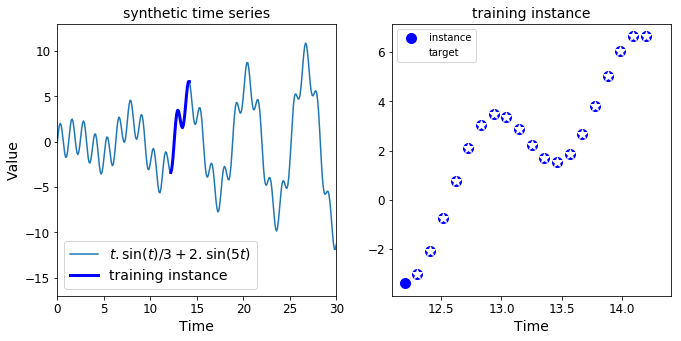

In [12]:
plt.figure(figsize=(11,5))

# left hand plot
plt.subplot(1,2,1)
plt.title("synthetic time series", fontsize=14)
plt.plot(t, time_series(t), 
         label=r"$t . \sin(t) / 3 + 2 . \sin(5t)$")
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), 
         "b-", linewidth=3, label="training instance")
plt.legend(loc="lower left", fontsize=14)
plt.axis([0, 30, -17, 13])
plt.xlabel("Time")
plt.ylabel("Value")

# right hand plot
plt.subplot(1,2,2)
plt.title("training instance", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), 
         "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), 
         "w*", markersize=10, label="target")
plt.legend(loc="upper left")
plt.xlabel("Time")
plt.show();

In [6]:
x_batch, y_batch = next_batch(1, STEPS)
np.c_[x_batch[0], y_batch[0]]

array([[  5.57025476,   5.61282718],
       [  5.61282718,   5.24911455],
       [  5.24911455,   4.37143712],
       [  4.37143712,   2.98878534],
       [  2.98878534,   1.22662768],
       [  1.22662768,  -0.70171278],
       [ -0.70171278,  -2.54512574],
       [ -2.54512574,  -4.07398805],
       [ -4.07398805,  -5.13415478],
       [ -5.13415478,  -5.68247048],
       [ -5.68247048,  -5.79512867],
       [ -5.79512867,  -5.64685558],
       [ -5.64685558,  -5.4660366 ],
       [ -5.4660366 ,  -5.47679394],
       [ -5.47679394,  -5.84221771],
       [ -5.84221771,  -6.62266931],
       [ -6.62266931,  -7.75938479],
       [ -7.75938479,  -9.08740994],
       [ -9.08740994, -10.37471602],
       [-10.37471602, -11.37793321]])

In [7]:
# setup
TRAINING_STEPS = 20
INPUTS = 1
NEURONS = 100
OUTPUTS = 1

reset_graph()

X = tf.placeholder(tf.float32, [None, TRAINING_STEPS, INPUTS])
Y = tf.placeholder(tf.float32, [None, TRAINING_STEPS, OUTPUTS])

cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=NEURONS, activation=tf.nn.relu),
    output_size=OUTPUTS)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [8]:
# training
LEARNING_RATE = 0.001

loss = tf.reduce_mean(tf.square(outputs - Y)) # MSE loss function
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE)
training_op = optimizer.minimize(loss)

loss_summary = tf.summary.scalar('LOSS', loss)
file_writer = tf.summary.FileWriter(log_dir('ts_RNN'), tf.get_default_graph())

init = tf.global_variables_initializer()

saver = tf.train.Saver()

%mkdir './sessions'
ITERATIONS = 1500
BATCH_SIZE = 50
SESSION_FILE = './sessions/timeseries_RNN'
print(SESSION_FILE)

with tf.Session() as session:
    init.run()
    for iteration in range(ITERATIONS):
        x_batch, y_batch = next_batch(BATCH_SIZE, TRAINING_STEPS)
        session.run(training_op, feed_dict={X:x_batch, Y:y_batch})
        if iteration % 10 == 0:
            mse = loss.eval(feed_dict={X:x_batch, Y:y_batch})
            file_writer.add_summary(loss_summary.eval(feed_dict={X:x_batch, Y:y_batch}), 
                                    iteration)
            #print(iteration, "\tMSE:", mse)
    saver.save(session, SESSION_FILE)

mkdir: cannot create directory ‘./sessions’: File exists
./sessions/timeseries_RNN


In [9]:
# prediction
with tf.Session() as session:
    saver.restore(session, SESSION_FILE)
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, STEPS, INPUTS)))
    Y_prediction = session.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./sessions/timeseries_RNN


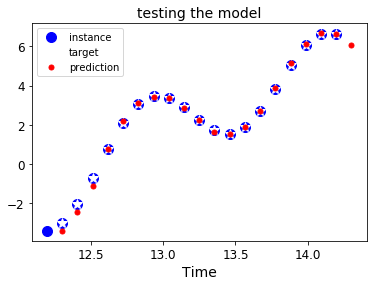

In [10]:
plt.title("testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], Y_prediction[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

Based on example avaiable at:

Géron, Aurélien. _"Hands-On Machine Learning with Scikit-Learn and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems"_ (388-391). O'Reilly Media. Kindle Edition. 2017